# 短程-建立模型

**相關性熱圖**

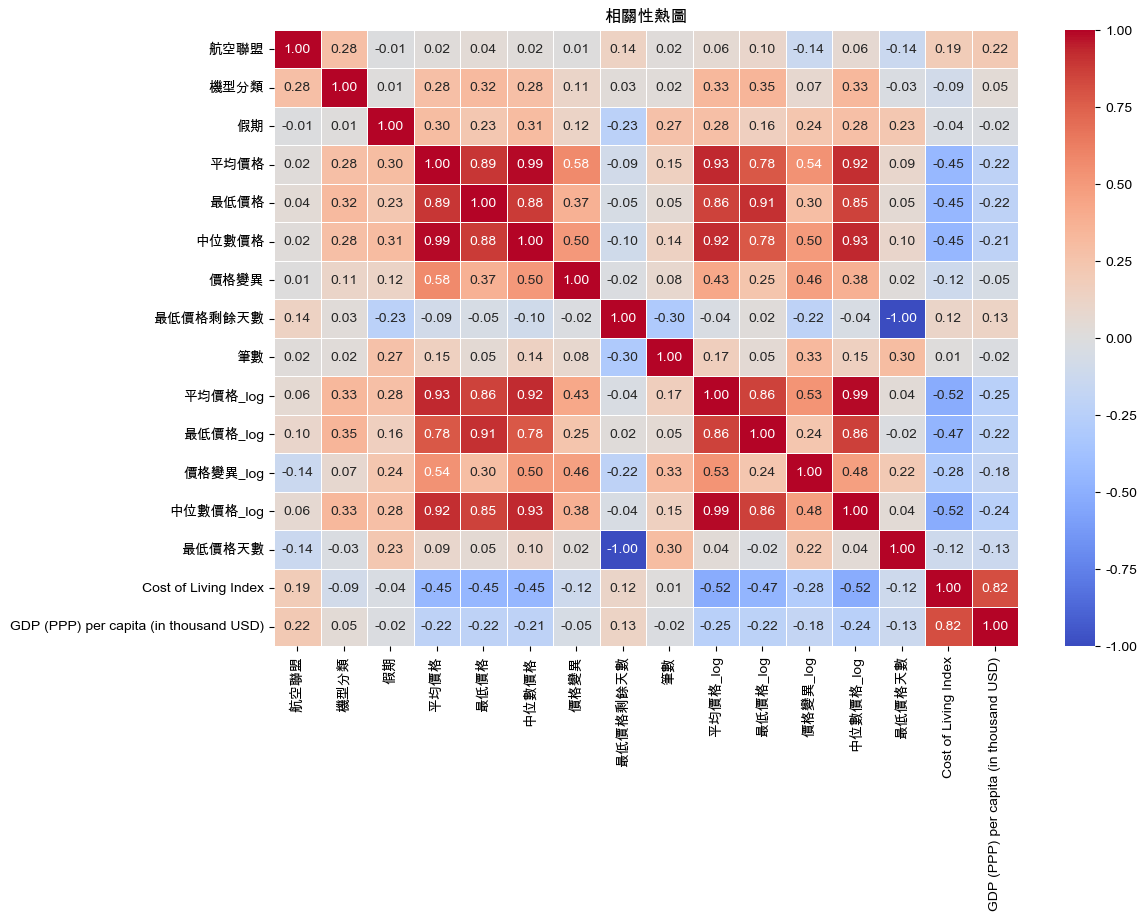

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 讀取數據
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/short_flight_final.csv'
data = pd.read_csv(file_path)

# 繁體中文設定
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 計算相關係數矩陣
correlation_matrix = data.corr(numeric_only=True)

# 繪製相關性熱圖
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("相關性熱圖")
plt.show()

**線性模型**

In [1]:
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# 讀取數據
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/short_flight_final.csv'
data = pd.read_csv(file_path)

# 將「飛行時間」轉換為分鐘數
def convert_flight_time_to_minutes(time_str):
    if isinstance(time_str, str):  # 確保是字串才處理
        # 使用正則表達式提取小時和分鐘
        match = re.match(r'(\d+) 小時(?: (\d+) 分鐘)?', time_str)
        if match:
            hours = int(match.group(1))
            minutes = int(match.group(2)) if match.group(2) else 0
            return hours * 60 + minutes
    return None  # 如果不是字串或無法解析則返回 None

data['飛行時間_分鐘'] = data['飛行時間'].apply(convert_flight_time_to_minutes)

# 轉換日期格式
data['出發日期'] = pd.to_datetime(data['出發日期'])

# 對以下欄位進行 one-hot encoding（drop_first 用來避免共線性）
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                    '航空公司', '航空聯盟', '是否過夜', '機型', '機型分類', '艙等', '假期', 'Region']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 數值型特徵處理
num_cols = ['飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# ==========================================
# 選取建模時使用的特徵：
# 我們要使用與「出發時段」、「抵達時段」、「航空聯盟」、「機型分類」、「假期」、「Region」相關的 dummy 變數
# 以及數值特徵「飛行時間_分鐘」、「Cost of Living Index」、「GDP (PPP) per capita (in thousand USD)」
# ==========================================

# 找出所有欄位名稱中包含目標關鍵字的 dummy 變數
target_keywords = ['出發時段_', '抵達時段_', '航空聯盟_', '機型分類_', '假期_', 'Region_']

dummy_cols = [col for col in data.columns if any(keyword in col for keyword in target_keywords)]

# 最後的特徵欄位：dummy 變數 + 數值特徵
feature_cols = dummy_cols + ['飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']

# 檢查選取的特徵
print("選取的特徵欄位:", feature_cols)

# 定義自變數與目標變數
X = data[feature_cols]
y = data["最低價格天數"]

# 分割數據集（訓練集與測試集）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 建立線性回歸模型
model = LinearRegression()
model.fit(X_train, y_train)

# 模型預測
y_pred = model.predict(X_test)

# 模型評估
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("測試集 MSE:", mse)
print("測試集 R^2:", r2)

選取的特徵欄位: ['出發時段_下午班機', '出發時段_凌晨班機', '出發時段_早晨班機', '出發時段_晚間班機', '抵達時段_下午抵達', '抵達時段_凌晨抵達', '抵達時段_早晨抵達', '抵達時段_晚間抵達', '航空聯盟_1', '航空聯盟_2', '航空聯盟_3', '航空聯盟_4', '機型分類_0', '機型分類_1', '機型分類_2', '假期_1', 'Region_日本', 'Region_泰國', 'Region_韓國', 'Region_香港', '飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']
測試集 MSE: 482.2417614392806
測試集 R^2: 0.12084354939283226


**隨機森林**

選取的特徵欄位: ['出發時段_下午班機', '出發時段_凌晨班機', '出發時段_早晨班機', '出發時段_晚間班機', '抵達時段_下午抵達', '抵達時段_凌晨抵達', '抵達時段_早晨抵達', '抵達時段_晚間抵達', '航空聯盟_1', '航空聯盟_2', '航空聯盟_3', '航空聯盟_4', '機型分類_0', '機型分類_1', '機型分類_2', '假期_1', 'Region_日本', 'Region_泰國', 'Region_韓國', 'Region_香港', '飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']
隨機森林 測試集 MSE: 433.0066925155233
隨機森林 測試集 R^2: 0.2106021142902853


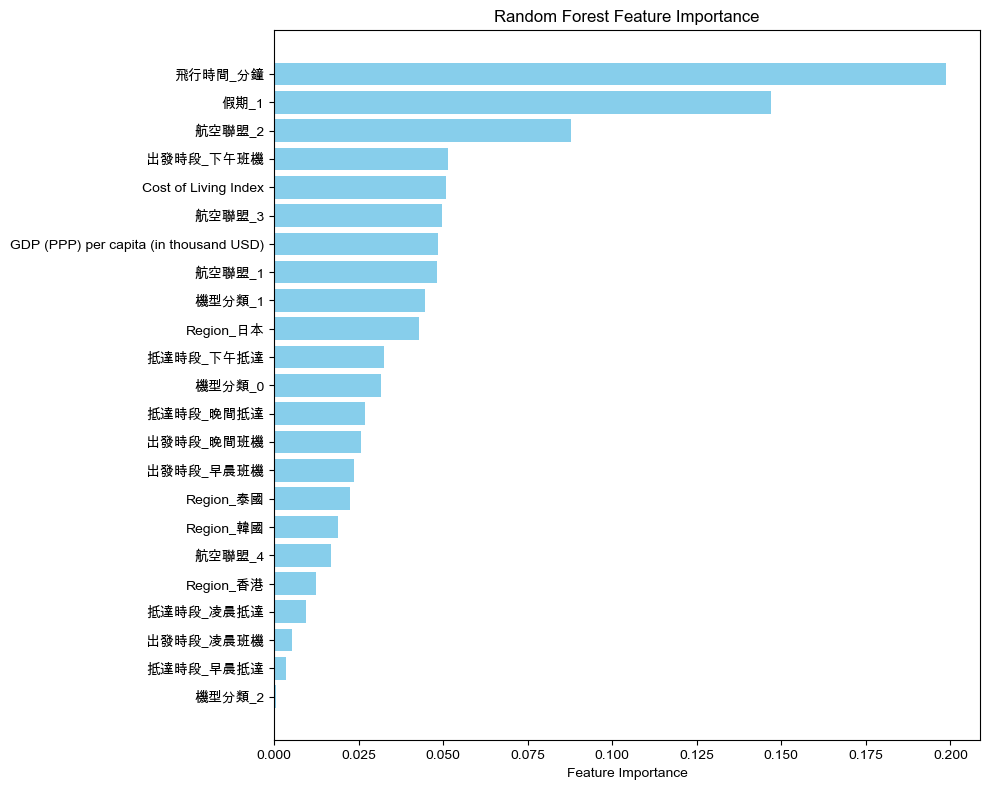

In [4]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# 讀取數據
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/short_flight_final.csv'
data = pd.read_csv(file_path)

# 將「飛行時間」轉換為分鐘數
def convert_flight_time_to_minutes(time_str):
    if isinstance(time_str, str):  # 確保是字串才處理
        # 使用正則表達式提取小時和分鐘
        match = re.match(r'(\d+) 小時(?: (\d+) 分鐘)?', time_str)
        if match:
            hours = int(match.group(1))
            minutes = int(match.group(2)) if match.group(2) else 0
            return hours * 60 + minutes
    return None  # 如果不是字串或無法解析則返回 None

data['飛行時間_分鐘'] = data['飛行時間'].apply(convert_flight_time_to_minutes)

# 轉換日期格式
data['出發日期'] = pd.to_datetime(data['出發日期'])

# 對以下欄位進行 one-hot encoding（drop_first 用來避免共線性）
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                    '航空公司', '航空聯盟', '是否過夜', '機型', '機型分類', '艙等', '假期', 'Region']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 數值型特徵處理
num_cols = ['飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# ==========================================
# 選取建模時使用的特徵：
# 我們要使用與「出發時段」、「抵達時段」、「航空聯盟」、「機型分類」、「假期」、「Region」相關的 dummy 變數
# 以及數值特徵「飛行時間_分鐘」、「Cost of Living Index」、「GDP (PPP) per capita (in thousand USD)」
# ==========================================

# 找出所有欄位名稱中包含目標關鍵字的 dummy 變數
target_keywords = ['出發時段_', '抵達時段_', '航空聯盟_', '機型分類_', '假期_', 'Region_']

dummy_cols = [col for col in data.columns if any(keyword in col for keyword in target_keywords)]

# 最後的特徵欄位：dummy 變數 + 數值特徵
feature_cols = dummy_cols + ['飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']
print("選取的特徵欄位:", feature_cols)

# 定義自變數與目標變數
X = data[feature_cols]
y = data["最低價格天數"]

# 分割數據集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------------------
# 使用隨機森林迴歸器
# ----------------------------
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 預測與評估
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("隨機森林 測試集 MSE:", mse_rf)
print("隨機森林 測試集 R^2:", r2_rf)

# ----------------------------
# 繪製特徵重要性圖
# ----------------------------
importances = rf_model.feature_importances_
# 建立一個 DataFrame 以便排序與繪圖
feat_imp_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=True)

# 繪製橫向條形圖
plt.figure(figsize=(10, 8))
plt.barh(feat_imp_df['feature'], feat_imp_df['importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

**SVM**

In [5]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# 讀取數據
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/short_flight_final.csv'
data = pd.read_csv(file_path)

# 將「飛行時間」轉換為分鐘數
def convert_flight_time_to_minutes(time_str):
    if isinstance(time_str, str):  # 確保是字串才處理
        # 使用正則表達式提取小時和分鐘
        match = re.match(r'(\d+) 小時(?: (\d+) 分鐘)?', time_str)
        if match:
            hours = int(match.group(1))
            minutes = int(match.group(2)) if match.group(2) else 0
            return hours * 60 + minutes
    return None  # 如果不是字串或無法解析則返回 None

data['飛行時間_分鐘'] = data['飛行時間'].apply(convert_flight_time_to_minutes)

# 轉換日期格式
data['出發日期'] = pd.to_datetime(data['出發日期'])

# 對以下欄位進行 one-hot encoding（drop_first 用來避免共線性）
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                    '航空公司', '航空聯盟', '是否過夜', '機型', '機型分類', '艙等', '假期', 'Region']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 數值型特徵處理
num_cols = ['飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# ==========================================
# 選取建模時使用的特徵：
# 使用與「出發時段」、「抵達時段」、「航空聯盟」、「機型分類」、「假期」、「Region」相關的 dummy 變數
# 以及數值特徵「飛行時間_分鐘」、「Cost of Living Index」、「GDP (PPP) per capita (in thousand USD)」
# ==========================================

# 找出所有欄位名稱中包含目標關鍵字的 dummy 變數
target_keywords = ['出發時段_', '抵達時段_', '航空聯盟_', '機型分類_', '假期_', 'Region_']
dummy_cols = [col for col in data.columns if any(keyword in col for keyword in target_keywords)]

# 最後的特徵欄位：dummy 變數 + 數值特徵
feature_cols = dummy_cols + ['飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']
print("選取的特徵欄位:", feature_cols)

# 定義自變數與目標變數
X = data[feature_cols]
y = data["最低價格天數"]

# 分割數據集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------------------
# 使用支持向量迴歸器 (SVR)
# ----------------------------
# 這裡預設使用 RBF 核，你可以根據需要調整參數（如 C, gamma 等）
svr_model = SVR(kernel='rbf', C=1.0, gamma='scale')
svr_model.fit(X_train, y_train)

# 預測與評估
y_pred_svr = svr_model.predict(X_test)
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print("SVR 測試集 MSE:", mse_svr)
print("SVR 測試集 R^2:", r2_svr)

選取的特徵欄位: ['出發時段_下午班機', '出發時段_凌晨班機', '出發時段_早晨班機', '出發時段_晚間班機', '抵達時段_下午抵達', '抵達時段_凌晨抵達', '抵達時段_早晨抵達', '抵達時段_晚間抵達', '航空聯盟_1', '航空聯盟_2', '航空聯盟_3', '航空聯盟_4', '機型分類_0', '機型分類_1', '機型分類_2', '假期_1', 'Region_日本', 'Region_泰國', 'Region_韓國', 'Region_香港', '飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']
SVR 測試集 MSE: 474.2883365256203
SVR 測試集 R^2: 0.1353431331625896


**XGBoost**

In [6]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# ------------------------------
# 數據預處理部分
# ------------------------------

# 讀取數據
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/short_flight_final.csv'
data = pd.read_csv(file_path)

# 將「飛行時間」轉換為分鐘數
def convert_flight_time_to_minutes(time_str):
    if isinstance(time_str, str):
        match = re.match(r'(\d+) 小時(?: (\d+) 分鐘)?', time_str)
        if match:
            hours = int(match.group(1))
            minutes = int(match.group(2)) if match.group(2) else 0
            return hours * 60 + minutes
    return None

data['飛行時間_分鐘'] = data['飛行時間'].apply(convert_flight_time_to_minutes)

# 轉換日期格式
data['出發日期'] = pd.to_datetime(data['出發日期'])

# 對以下欄位進行 one-hot encoding（drop_first 用來避免共線性）
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                    '航空公司', '航空聯盟', '是否過夜', '機型', '機型分類', '艙等', '假期', 'Region']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 數值型特徵處理
num_cols = ['飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# ==========================================
# 選取建模時使用的特徵：
# 我們要使用與「出發時段」、「抵達時段」、「航空聯盟」、「機型分類」、「假期」、「Region」相關的 dummy 變數
# 以及數值特徵「飛行時間_分鐘」、「Cost of Living Index」、「GDP (PPP) per capita (in thousand USD)」
# ==========================================

# 找出所有欄位名稱中包含目標關鍵字的 dummy 變數
target_keywords = ['出發時段_', '抵達時段_', '航空聯盟_', '機型分類_', '假期_', 'Region_']

dummy_cols = [col for col in data.columns if any(keyword in col for keyword in target_keywords)]

# 最後的特徵欄位：dummy 變數 + 數值特徵
feature_cols = dummy_cols + ['飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']
print("選取的特徵欄位:", feature_cols)

# 定義自變數與目標變數
X = data[feature_cols]
y = data["最低價格天數"]

# 分割數據集 (訓練集、測試集)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------------------
# 使用 XGBoost 進行迴歸
# ------------------------------

# 直接建立 XGBRegressor 模型
xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

# 預測與評估
y_pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost 測試集 MSE:", mse_xgb)
print("XGBoost 測試集 R^2:", r2_xgb)

選取的特徵欄位: ['出發時段_下午班機', '出發時段_凌晨班機', '出發時段_早晨班機', '出發時段_晚間班機', '抵達時段_下午抵達', '抵達時段_凌晨抵達', '抵達時段_早晨抵達', '抵達時段_晚間抵達', '航空聯盟_1', '航空聯盟_2', '航空聯盟_3', '航空聯盟_4', '機型分類_0', '機型分類_1', '機型分類_2', '假期_1', 'Region_日本', 'Region_泰國', 'Region_韓國', 'Region_香港', '飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']
XGBoost 測試集 MSE: 433.7737878998464
XGBoost 測試集 R^2: 0.20920366048812866
